In [17]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_ollama import ChatOllama
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

import requests
import random

In [18]:
load_dotenv()

True

In [19]:
import os


OLLAMA_HOST = os.getenv("OLLAMA_HOST")
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL")
model = ChatOllama(
        model=OLLAMA_MODEL,
        base_url=OLLAMA_HOST,
        temperature=0.2,        # critical for factual stability
        # num_predict=800,        # max tokens to generate
        timeout=60              # avoid hanging workers
    )

In [20]:
# tools

search_tool = DuckDuckGoSearchRun(region="us", safesearch="Moderate")

@tool
def calculator_tool(first_num: int , second_number: int, operation: str) -> str:
    """A simple calculator tool that can add, subtract, multiply, or divide two numbers."""
    if operation == "add":
        return str(first_num + second_number)
    elif operation == "subtract":
        return str(first_num - second_number)
    elif operation == "multiply":
        return str(first_num * second_number)
    elif operation == "divide":
        if second_number == 0:
            return "Error: Division by zero"
        return str(first_num / second_number)
    else:
        return "Error: Unsupported operation. Please use add, subtract, multiply, or divide."
    
@tool
def get_stock_price(symbol: str) -> str:
    """
    A tool to get the current stock price for a given stock symbol using a free API.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=C9PE94QUEW9VWGFM"
    r = requests.get(url)
    return r.json()

In [21]:
tools_list = [search_tool, calculator_tool, get_stock_price]

model_with_tools = model.bind_tools(
    tools=tools_list)

In [22]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages()]

In [23]:
# graph nodes

def chat_node(state: ChatState) -> ChatState:
    """
    LLM chat node that may answer or request a tool call
    """
    response = model_with_tools.invoke(state["messages"])
    state["messages"].append(response)
    return state

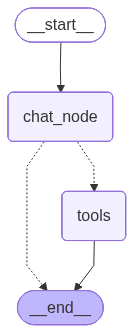

In [27]:
graph = StateGraph(ChatState)
tool_node = ToolNode(tools_list)

graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", END)

chatbot = graph.compile()
chatbot

In [29]:
out = chatbot.invoke({
    "messages": [HumanMessage(content="Hello, how are you?")]
})
print(out["messages"][-1].content)

I'm doing well, thank you! How can I assist you today?


In [31]:
# chat requiring too use

out = chatbot.invoke({
    "messages": [HumanMessage(content="What is the current stock price of apple?")]
})
print(out["messages"][-1].content)

{"Global Quote": {"01. symbol": "AAPL", "02. open": "249.2000", "03. high": "251.0000", "04. low": "248.1500", "05. price": "248.3500", "06. volume": "39708340", "07. latest trading day": "2026-01-22", "08. previous close": "247.6500", "09. change": "0.7000", "10. change percent": "0.2827%"}}


In [33]:
out = chatbot.invoke({
    "messages": [HumanMessage(content="What is 4 multiply with 8?")]
})
out["messages"][-1].content

'32'

In [40]:
out = chatbot.invoke({"messages": [HumanMessage(content="what is the top news today?")]})
last_msg = out["messages"][-1]

print(last_msg.content)
print(last_msg.usage_metadata)



CBS News offers breaking news coverage of today 's top headlines. Stay informed on the biggest new stories with our balanced, trustworthy reporting. Read full articles, watch videos, browse thousands of titles and more on the "Headlines" topic with Google News . Read the latest headlines, breaking news , and videos at APNews.com, the definitive source for independent journalism from every corner of the globe. Go to NBCNews.com for breaking news , videos, and the latest top stories in world news , business, politics, health and pop culture. Jack Smith testimony Ukraine peace talks Live 24/7 Coverage of Breaking News and Live Events.


AttributeError: 'ToolMessage' object has no attribute 'usage_metadata'